In [5]:
import os,sys
import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft
from glob import glob
from time import time
import tensorflow as tf

from sklearn.metrics import average_precision_score

%matplotlib inline

In [3]:
sys.path.insert(0,'library\\')
import config
import diagnostics
import base_model

## data lookup

In [2]:
def LoadData(song):
    data_paths = sorted(glob(f"processed_dataset\\feat\\{song}-*.npy", recursive=True))
    lebel_paths = sorted(glob(f"processed_dataset\\label\\{song}-*.npy", recursive=True))
    data = []
    label = []
    
    for i in range(len(data_paths)) : 
        data.append(np.load(data_paths[i],"r").tolist())
        label.append(np.load(lebel_paths[i],"r").tolist())
    return data,label

In [6]:
data, label  = LoadData(1727)

In [6]:
datas, labels = {},{}
datas[1727-00] = data
labels[1727-00] = label

data : list of list [1500] <br>
data[i] = wav after pass the filter bank in scale [0,120]

label : list of list [1500] <br>
label[i] = 0/1 of if note in index (0-88) is playing


In [ ]:
x=np.arange(0,len(label))
for i in range(len(label)):
    for j in range(88) :
        if(label[i][j]==1) :
            plt.scatter(i,j, s=2,c="b") 
plt.show()

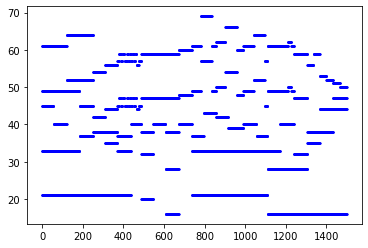

In [73]:
x=np.arange(0,len(label))
for i in range(len(label)):
    #plt.plot([pt[i] for pt in label])
    for j in range(88) :
        if(label[i][j]==1) :
            plt.scatter(i,j, s=2,c="b") 
plt.show()

## spectrogram

In [39]:
class Spectrograms(base_model.Model):
#class Spectrograms():
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512              # lvl1 nodes
        self.d = 4096              # lvl1 receptive field
        
        self.k2 = 512              # lvl2 nodes

        # number of lvl1 features
        regions = 1 + (self.window - self.d)/self.stride
        print('Number of V1 feature regions: {}'.format(regions))

        wscale = 10e-3
        with tf.compat.v1.variable_scope('parameters'):
            w = tf.Variable(wscale*tf.compat.v1.random_normal([1,self.d,1,self.k],seed=999))
            wavg = self.register_weights(w,'w',average=.9998)
            w1 = tf.Variable(wscale*tf.compat.v1.random_normal([(int)(regions*self.k),self.k2],seed=999))
            w1avg = self.register_weights(w1,'w1',average=.9998)
            beta = tf.Variable(wscale*tf.compat.v1.random_normal([self.k2,self.m],seed=999))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.compat.v1.variable_scope('queued_model'):
            zx = tf.compat.v1.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xq,w,strides=[1,1,self.stride,1],padding='VALID')))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(zx,[int(self.batch_size),(int)(regions*self.k)]),w1))
            y = tf.matmul(z2,beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.compat.v1.variable_scope('direct_model'):
            zx = tf.compat.v1.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xd,wavg,strides=[1,1,self.stride,1],padding='VALID')))
            z2 = tf.nn.relu(tf.matmul(tf.reshape(zx,[tf.shape(self.xd)[0],int(regions*self.k)]),w1avg))
            self.y_direct = tf.matmul(z2,betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [40]:
#using dataframe แทน list ที่มี key [อาจจะเป็น dict มั้ง]
import pandas as pd
df = pd.DataFrame(list(zip(data, label)), columns =['feat', 'label'])

In [1]:
#sys.path.insert(0,'library/')
sys.path.append("library/")
import base_model

lb={}
lb[1727]=label
model = Spectrograms(df,checkpoint_path='convnet_mlp_raw/', outputs=1, window=16384, mmap=True, batch_size=100,
                    normalize=True, extended_test_set=True, use_mirex=False, init=False, pitch_transforms=5, jitter=.1,
                    restrict=False)

Instructions for updating:
non-resource variables are not supported in the long term


NameError: name 'label' is not defined

In [95]:
lr = .001/3/3/3
mom = .95

# stop the model if it is already running
#model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print(model.status_header())
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print(model.status())
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    model.checkpoint()
    print('Graceful Exit')
finally:
    model.stop()

NameError: name 'model' is not defined